In [2]:
# =========================
# Cell 1: Imports & Data Load
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# --- Load datasets (update paths if needed) ---
sleep_path = 'Sleep_health_and_lifestyle_dataset.csv'
dreams_path = 'dream_symbols.csv'

df_sleep = pd.read_csv(sleep_path)
df_dreams = pd.read_csv(dreams_path)

print("Sleep dataset shape:", df_sleep.shape)
print("Dream dataset shape:", df_dreams.shape)
df_sleep.head()


Sleep dataset shape: (374, 13)
Dream dataset shape: (7798, 5)


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [3]:
# =========================
# Cell 2: Random Dream Assignment
# =========================

# Randomly assign a dream narrative to each person in the sleep dataset
rng = np.random.default_rng(42)
rand_idx = rng.integers(0, len(df_dreams), size=len(df_sleep))

# Assuming the dream meaning column is named 'meaning'
df_sleep['Dream Narrative'] = df_dreams.loc[rand_idx, 'meaning'].values

# Drop records where dream narrative is missing (if any)
df_sleep = df_sleep.dropna(subset=['Dream Narrative']).reset_index(drop=True)

print("After assigning dreams:", df_sleep.shape)
df_sleep[['Person ID', 'Dream Narrative']].head()


After assigning dreams: (374, 14)


,Person ID,Dream Narrative
0,1,signifies the influence of evil around you.
1,2,symbolizes limited independence. You are bein...
2,3,suggests that you are taking a passive role i...
3,4,symbolize delayed success.
4,5,signifies your tendency to procrastinate and ...


In [4]:
# =========================
# Cell 3: EDA & Correlation Matrix
# =========================

# Show basic statistics for numeric columns
print(df_sleep.describe(include='all').transpose().head(15))

# Select numeric columns and compute correlation
num_df = df_sleep.select_dtypes(include=['number'])
corr = num_df.corr()

# Correlation of each variable with (original) Sleep Quality (for report context)
if 'Quality of Sleep' in num_df.columns:
    print("\nCorrelation with Quality of Sleep:")
    print(corr['Quality of Sleep'].sort_values(ascending=False))

# We'll recompute correlation with the new CompositeSleepScore later.


                         count unique  \
Person ID                374.0    NaN   
Gender                     374      2   
Age                      374.0    NaN   
Occupation                 374     11   
Sleep Duration           374.0    NaN   
Quality of Sleep         374.0    NaN   
Physical Activity Level  374.0    NaN   
Stress Level             374.0    NaN   
BMI Category               374      4   
Blood Pressure             374     25   
Heart Rate               374.0    NaN   
Daily Steps              374.0    NaN   
Sleep Disorder             155      2   
Dream Narrative            374    365   

                                                                     top freq  \
Person ID                                                            NaN  NaN   
Gender                                                              Male  189   
Age                                                                  NaN  NaN   
Occupation                                                  

In [5]:
# =========================
# Cell 4: LDA Topic Modeling
# =========================

vectorizer = CountVectorizer(
    stop_words='english',
    max_features=1000,
    ngram_range=(1, 2)  # unigrams + bigrams
)
X_text = vectorizer.fit_transform(df_sleep['Dream Narrative'])

num_topics = 5
lda = LatentDirichletAllocation(
    n_components=num_topics,
    random_state=42
)
lda_topic_matrix = lda.fit_transform(X_text)

df_topics = pd.DataFrame(
    lda_topic_matrix,
    columns=[f'Topic_{k}' for k in range(num_topics)]
).reset_index(drop=True)

# Show top words for each topic (for report)
feature_names = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[-10:]
    top_words = [feature_names[i] for i in top_indices]
    print(f"\nTopic {idx}: {top_words}")



Topic 0: ['alternatively dream', 'emotions', 'new', 'signifies', 'suggests', 'need', 'dream', 'alternatively', 'indicates', 'life']

Topic 1: ['implies', 'time', 'things', 'alternatively', 'suggests need', 'represents', 'life', 'suggests', 'dream', 'need']

Topic 2: ['means', 'symbolizes', 'ref', 'situation', 'need', 'life', 'alternatively', 'indicates', 'dream', 'represents']

Topic 3: ['indicates', 'trying', 'situation', 'symbolizes', 'need', 'life', 'alternatively dream', 'suggests', 'alternatively', 'dream']

Topic 4: ['feel', 'sexual', 'need', 'feeling', 'alternatively', 'suggests', 'life', 'means', 'dream', 'indicates']


In [6]:
# =========================
# Cell 5: Composite Sleep Score (CP1 Logic - Recommended)
# =========================

df_sleep['CompositeSleepScore'] = (
    (df_sleep['Sleep Duration'] >= 7) &       # long enough sleep
    (df_sleep['Quality of Sleep'] > 6) &      # good self-reported quality
    (df_sleep['Stress Level'] < 5)            # relatively low stress
).astype(int)

print("\nCompositeSleepScore distribution:")
print(df_sleep['CompositeSleepScore'].value_counts())

# Optional: correlation with new target
num_df2 = df_sleep.select_dtypes(include=['number'])
corr2 = num_df2.corr()
print("\nCorrelation with CompositeSleepScore:")
print(corr2['CompositeSleepScore'].sort_values(ascending=False))



CompositeSleepScore distribution:
CompositeSleepScore
0    258
1    116
Name: count, dtype: int64

Correlation with CompositeSleepScore:
CompositeSleepScore        1.000000
Quality of Sleep           0.728803
Sleep Duration             0.613828
Age                        0.425514
Person ID                  0.365627
Physical Activity Level   -0.055254
Daily Steps               -0.199463
Heart Rate                -0.450985
Stress Level              -0.755643
Name: CompositeSleepScore, dtype: float64


In [7]:
# =========================
# FINAL FEATURE MATRIX (Fix Overfitting)
# =========================

df_sleep = df_sleep.reset_index(drop=True)
df_topics = df_topics.reset_index(drop=True)

df_struct = df_sleep[['Age', 'Gender', 'Sleep Duration',
                      'Physical Activity Level', 'Sleep Disorder']].copy()

# Encode Gender
df_struct['Gender'] = LabelEncoder().fit_transform(df_struct['Gender'])

# Convert Sleep Disorder to binary flag
df_struct['HasDisorder'] = (df_struct['Sleep Disorder'] != 'None').astype(int)
df_struct = df_struct.drop(columns=['Sleep Disorder'])

# Combine structured features with topic features
X = pd.concat([df_struct, df_topics], axis=1)
y = df_sleep['CompositeSleepScore']

print("Feature matrix shape:", X.shape)
print("Target distribution:\n", y.value_counts())


Feature matrix shape: (374, 10)
Target distribution:
 CompositeSleepScore
0    258
1    116
Name: count, dtype: int64


In [8]:
# =========================
# Cell 7: Train/Test Split & Scaling
# =========================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Standardization for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 261
Test size: 113


In [9]:
# =========================
# Cell 8: Train Models (LR, DT, RF)
# =========================

# Logistic Regression (baseline)
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)

# Decision Tree (baseline)
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

# Random Forest (final model)
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42
)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

def summarize_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"\n=== {name} ===")
    print("Accuracy:", round(acc, 4))
    print("Weighted F1:", round(f1, 4))
    print(classification_report(y_true, y_pred))
    return {"Model": name, "Accuracy": acc, "F1_weighted": f1}

results = []
results.append(summarize_model("Logistic Regression", y_test, y_pred_lr))
results.append(summarize_model("Decision Tree",       y_test, y_pred_tree))
results.append(summarize_model("Random Forest",       y_test, y_pred_rf))

results_df = pd.DataFrame(results)
print("\nSummary:")
print(results_df)



=== Logistic Regression ===
Accuracy: 0.9292
Weighted F1: 0.9272
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        78
           1       0.97      0.80      0.88        35

    accuracy                           0.93       113
   macro avg       0.94      0.89      0.91       113
weighted avg       0.93      0.93      0.93       113


=== Decision Tree ===
Accuracy: 0.9381
Weighted F1: 0.9387
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        78
           1       0.87      0.94      0.90        35

    accuracy                           0.94       113
   macro avg       0.92      0.94      0.93       113
weighted avg       0.94      0.94      0.94       113


=== Random Forest ===
Accuracy: 0.9646
Weighted F1: 0.964
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        78
           1       1.00      0.89      0.94        3


Top 15 feature importances:
Sleep Duration             0.405466
Age                        0.279512
Gender                     0.123082
Physical Activity Level    0.080217
Topic_3                    0.027532
Topic_2                    0.021976
Topic_1                    0.021440
Topic_0                    0.021182
Topic_4                    0.019593
HasDisorder                0.000000
dtype: float64


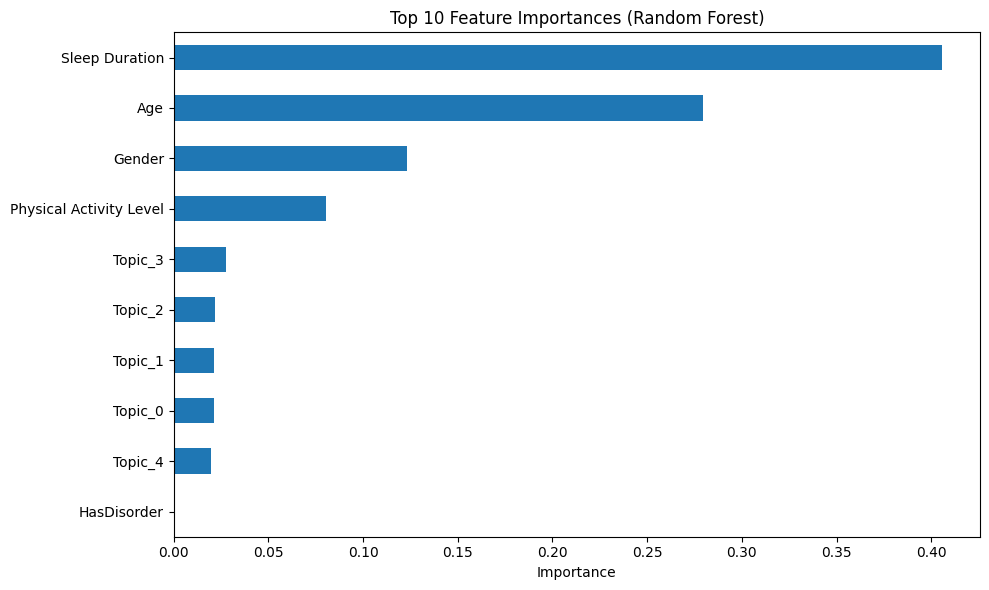

In [10]:
# =========================
# Cell 9: Feature Importances (Random Forest)
# =========================

importances = pd.Series(rf_clf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

print("\nTop 15 feature importances:")
print(importances_sorted.head(15))

plt.figure(figsize=(10, 6))
importances_sorted.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


#EDA

/tmp/ipython-input-2557634233.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['Poor Sleep', 'Good Sleep'])
/tmp/ipython-input-2557634233.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(['Poor Sleep', 'Good Sleep'])


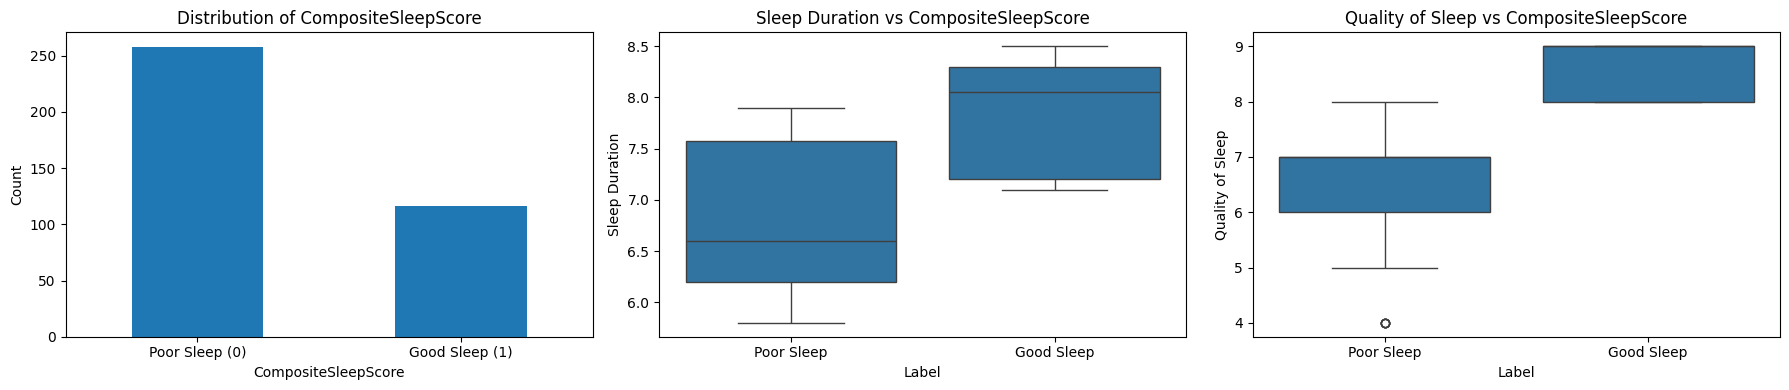

In [11]:
# =========================
# V1: EDA – Target + key features
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")

# 1) CompositeSleepScore distribution
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

df_sleep['CompositeSleepScore'].value_counts().sort_index().plot(
    kind='bar', ax=ax[0]
)
ax[0].set_xticklabels(['Poor Sleep (0)', 'Good Sleep (1)'], rotation=0)
ax[0].set_title('Distribution of CompositeSleepScore')
ax[0].set_ylabel('Count')

# 2) Sleep Duration by label
sns.boxplot(
    data=df_sleep,
    x='CompositeSleepScore',
    y='Sleep Duration',
    ax=ax[1]
)
ax[1].set_xticklabels(['Poor Sleep', 'Good Sleep'])
ax[1].set_title('Sleep Duration vs CompositeSleepScore')
ax[1].set_xlabel('Label')

# 3) Quality of Sleep by label
sns.boxplot(
    data=df_sleep,
    x='CompositeSleepScore',
    y='Quality of Sleep',
    ax=ax[2]
)
ax[2].set_xticklabels(['Poor Sleep', 'Good Sleep'])
ax[2].set_title('Quality of Sleep vs CompositeSleepScore')
ax[2].set_xlabel('Label')

plt.tight_layout()
plt.show()


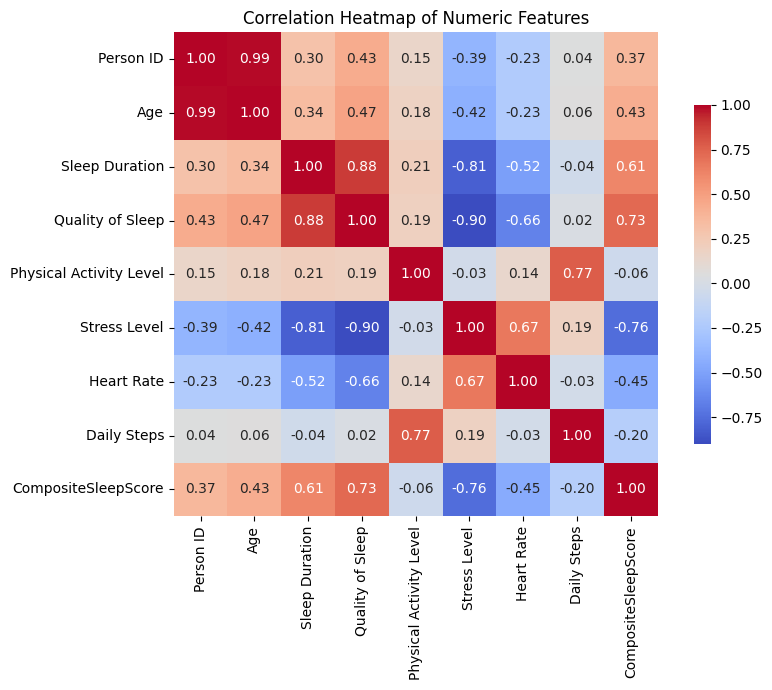

In [12]:
# =========================
# V2: Correlation heatmap
# =========================
import numpy as np

num_df = df_sleep.select_dtypes(include=[np.number])

plt.figure(figsize=(9, 7))
corr = num_df.corr()
sns.heatmap(
    corr,
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    square=True,
    cbar_kws={'shrink': 0.7}
)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()


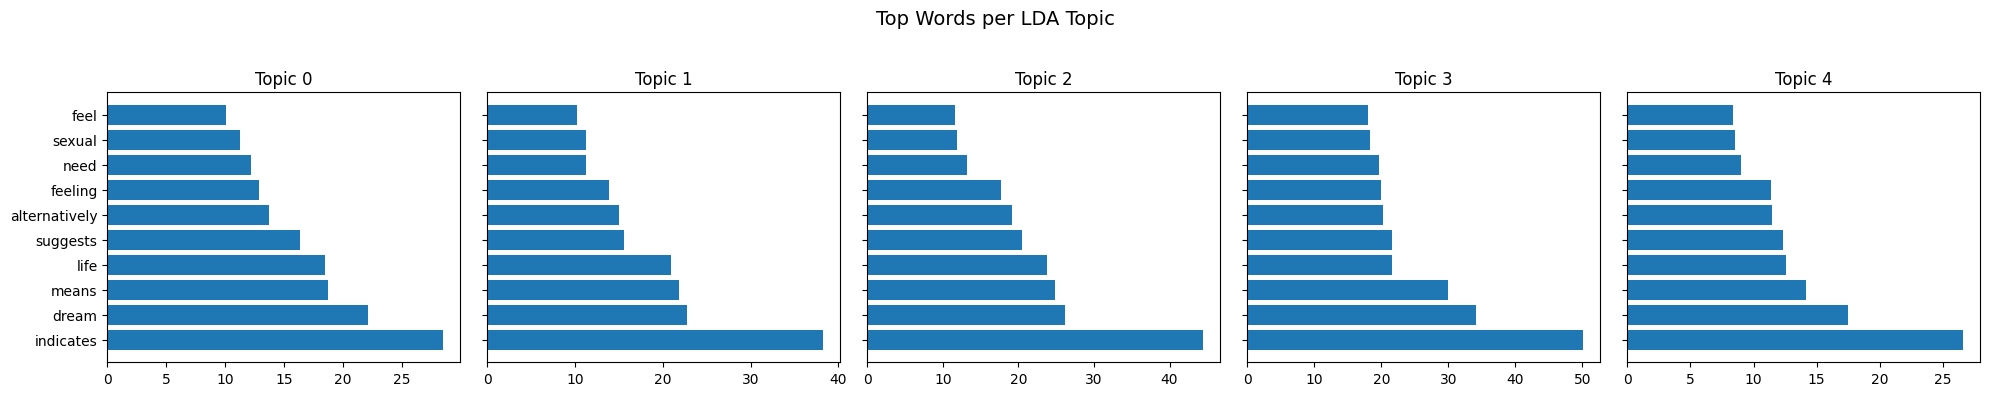

In [13]:
# =========================
# V3: Top words per LDA topic
# =========================
# assumes `lda` and `vectorizer` are already fitted
feature_names = vectorizer.get_feature_names_out()
n_top_words = 10

fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
fig.suptitle('Top Words per LDA Topic', fontsize=14)

for topic_idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[-n_top_words:]
    top_words = feature_names[top_indices]
    top_weights = topic[top_indices]

    ax = axes[topic_idx]
    ax.barh(range(n_top_words), top_weights)
    ax.set_yticks(range(n_top_words))
    ax.set_yticklabels(top_words)
    ax.invert_yaxis()
    ax.set_title(f'Topic {topic_idx}')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


<Figure size 800x500 with 0 Axes>

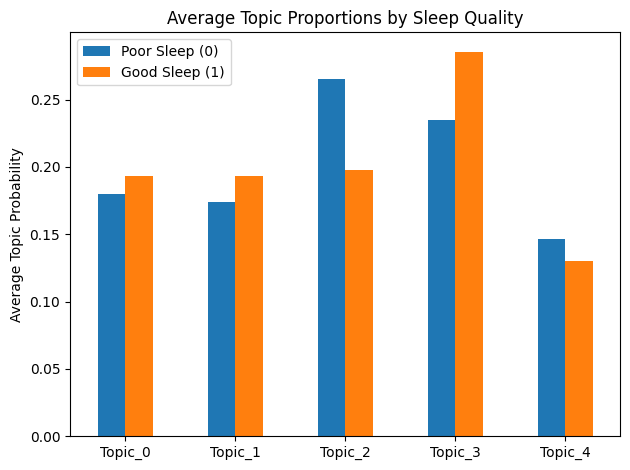

In [14]:
# =========================
# V4: Average topic proportions by CompositeSleepScore
# =========================
topics_with_label = df_topics.copy()
topics_with_label['CompositeSleepScore'] = df_sleep['CompositeSleepScore'].values

topic_means = topics_with_label.groupby('CompositeSleepScore').mean().T
topic_means.columns = ['Poor Sleep (0)', 'Good Sleep (1)']

plt.figure(figsize=(8, 5))
topic_means.plot(kind='bar')
plt.title('Average Topic Proportions by Sleep Quality')
plt.ylabel('Average Topic Probability')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


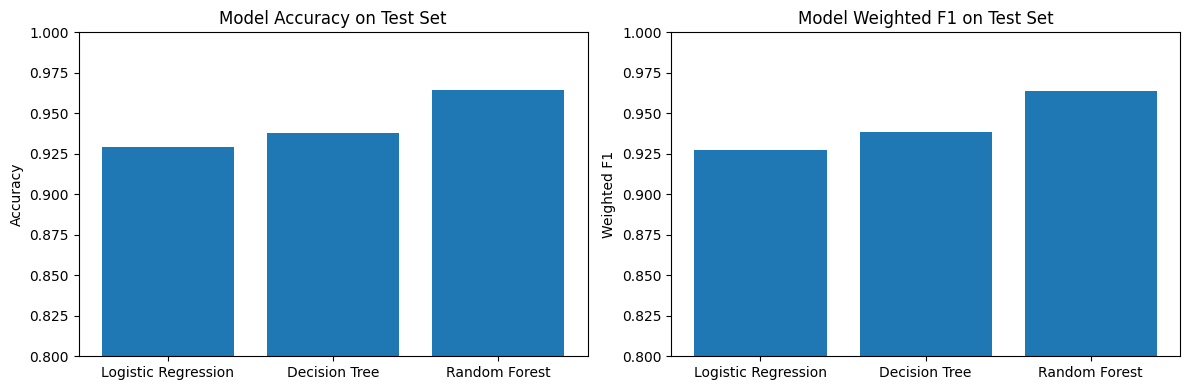

In [15]:
# =========================
# V5: Model performance comparison
# =========================

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy
ax[0].bar(results_df['Model'], results_df['Accuracy'])
ax[0].set_ylim(0.8, 1.0)
ax[0].set_title('Model Accuracy on Test Set')
ax[0].set_ylabel('Accuracy')

# Weighted F1
ax[1].bar(results_df['Model'], results_df['F1_weighted'])
ax[1].set_ylim(0.8, 1.0)
ax[1].set_title('Model Weighted F1 on Test Set')
ax[1].set_ylabel('Weighted F1')

plt.tight_layout()
plt.show()


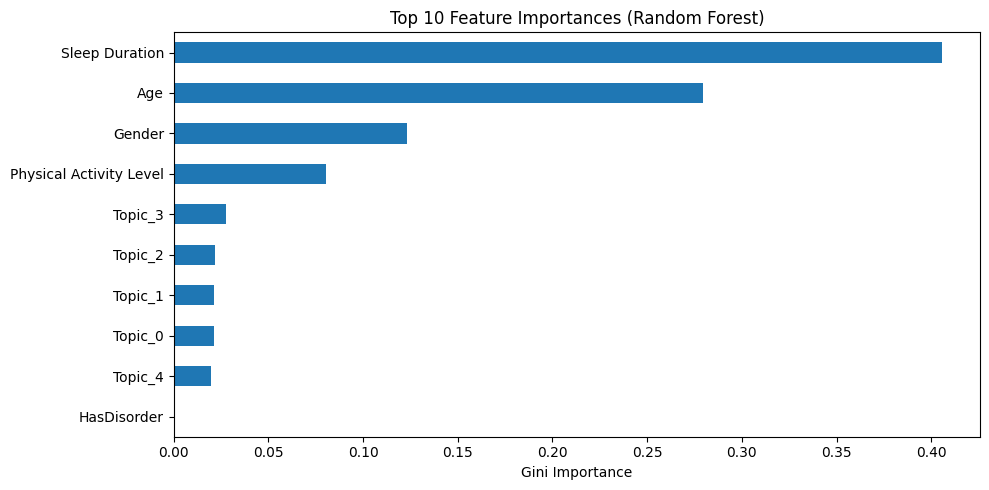

In [16]:
# =========================
# V6: Feature importances (RF with topics)
# =========================
import pandas as pd

rf_importances = pd.Series(rf_clf.feature_importances_, index=X.columns)
top10 = rf_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
top10.iloc[::-1].plot(kind='barh')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Gini Importance')
plt.tight_layout()
plt.show()


                    Model  Accuracy  F1_weighted
0      RF Structured Only  0.964602     0.964305
1  RF Structured + Topics  0.964602     0.963972


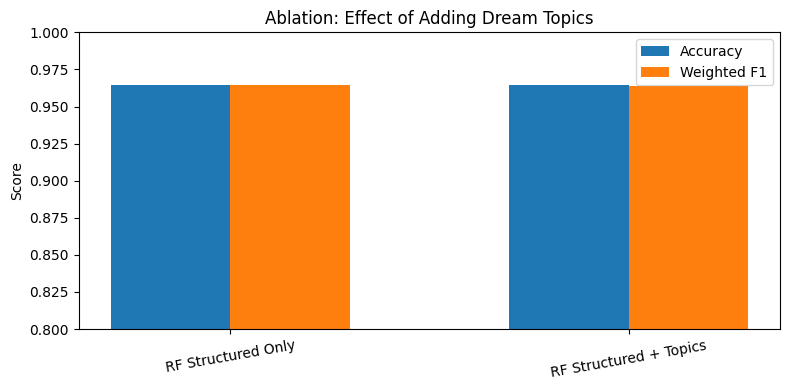

In [17]:
# =========================
# V7: Ablation – RF with vs without topic features
# =========================

# 1) Structured-only features (no topics)
structured_cols = ['Age', 'Gender', 'Sleep Duration',
                   'Physical Activity Level', 'HasDisorder']
X_struct_only = df_struct[structured_cols]

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_struct_only, y, test_size=0.3, random_state=42, stratify=y
)

rf_struct = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42
)
rf_struct.fit(X_train_s, y_train_s)
y_pred_struct = rf_struct.predict(X_test_s)

acc_struct = accuracy_score(y_test_s, y_pred_struct)
f1_struct = f1_score(y_test_s, y_pred_struct, average='weighted')

# 2) Multi-modal RF (existing rf_clf on X_train / X_test)
acc_multi = accuracy_score(y_test, y_pred_rf)
f1_multi = f1_score(y_test, y_pred_rf, average='weighted')

ablation_df = pd.DataFrame({
    'Model': ['RF Structured Only', 'RF Structured + Topics'],
    'Accuracy': [acc_struct, acc_multi],
    'F1_weighted': [f1_struct, f1_multi]
})
print(ablation_df)

# 3) Plot
plt.figure(figsize=(8, 4))
x_pos = np.arange(len(ablation_df))

plt.bar(x_pos - 0.15, ablation_df['Accuracy'], width=0.3, label='Accuracy')
plt.bar(x_pos + 0.15, ablation_df['F1_weighted'], width=0.3, label='Weighted F1')

plt.xticks(x_pos, ablation_df['Model'], rotation=10)
plt.ylim(0.8, 1.0)
plt.title('Ablation: Effect of Adding Dream Topics')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()


Generating Word Clouds for Dream Topics...


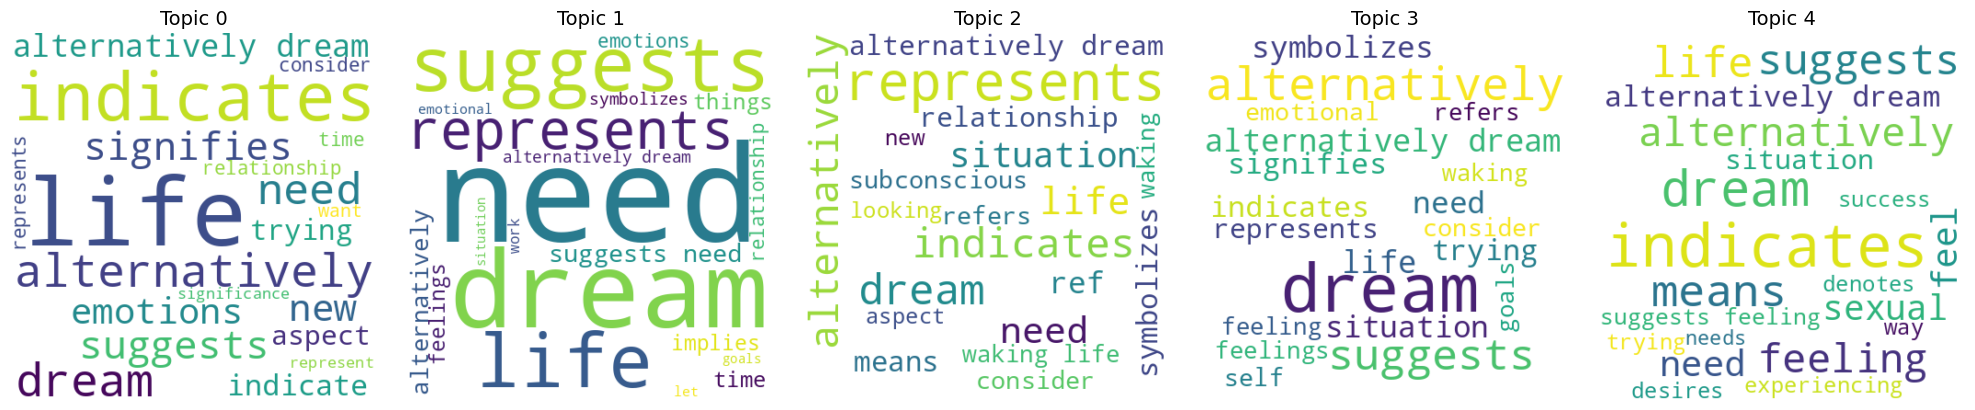

In [18]:
# --- Visualization 1: Robust Word Clouds for LDA Topics ---
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import math

def plot_lda_wordclouds(lda_model, vectorizer, n_words=20):
    # Robust check for sklearn versions (get_feature_names_out vs get_feature_names)
    try:
        feature_names = vectorizer.get_feature_names_out()
    except AttributeError:
        feature_names = vectorizer.get_feature_names()

    # Dynamically determine grid size based on number of topics
    n_topics = len(lda_model.components_)
    n_cols = 5
    n_rows = math.ceil(n_topics / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    # Flatten axes to make indexing easy, handle single topic case
    axes = axes.flatten() if n_topics > 1 else [axes]

    for topic_idx, topic in enumerate(lda_model.components_):
        top_features_ind = topic.argsort()[:-n_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        word_freq = dict(zip(top_features, weights))
        wc = WordCloud(background_color='white', width=400, height=400)
        wc.generate_from_frequencies(word_freq)

        ax = axes[topic_idx]
        ax.imshow(wc, interpolation='bilinear')
        ax.set_title(f'Topic {topic_idx}', fontsize=14)
        ax.axis('off')

    # Hide unused subplots
    for i in range(n_topics, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Ensure lda and vectorizer exist before running
if 'lda' in locals() and 'vectorizer' in locals():
    print("Generating Word Clouds for Dream Topics...")
    plot_lda_wordclouds(lda, vectorizer)
else:
    print("Error: 'lda' or 'vectorizer' not found. Please run the LDA modeling cell first.")

/tmp/ipython-input-3146358172.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


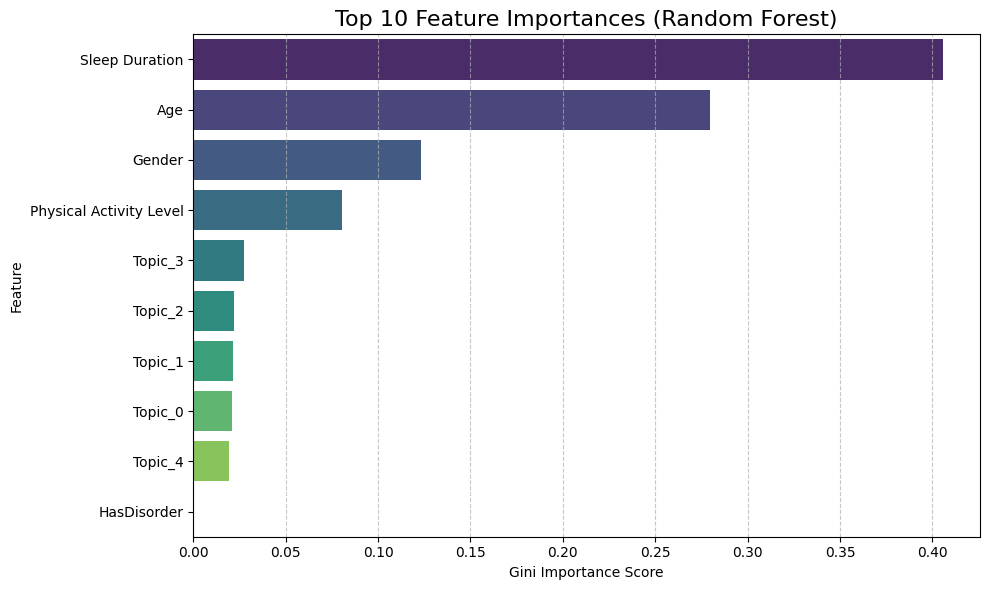

In [19]:
# --- Visualization: Random Forest Feature Importance ---
import seaborn as sns
import matplotlib.pyplot as plt

# Get feature importances and names
importances = rf_clf.feature_importances_
feature_names = X.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(10) # Top 10

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Top 10 Feature Importances (Random Forest)', fontsize=16)
plt.xlabel('Gini Importance Score')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

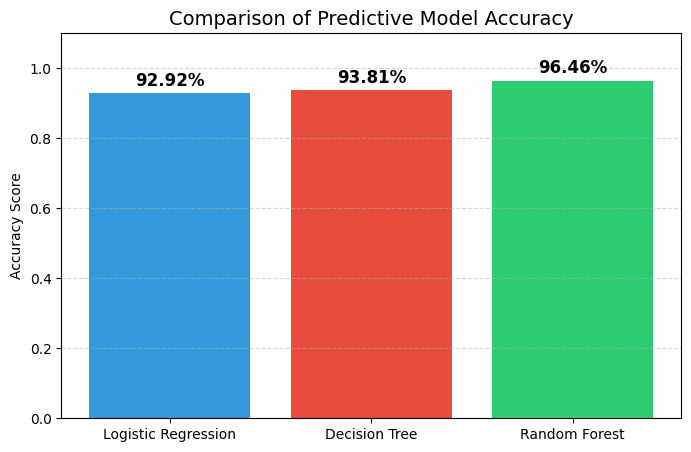

In [20]:
# --- Visualization: Model Performance Comparison ---
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame of results (Ensure you have run the modeling cells first)
model_scores = {
    'Logistic Regression': accuracy_score(y_test, y_pred_lr),
    'Decision Tree': accuracy_score(y_test, y_pred_tree),
    'Random Forest': accuracy_score(y_test, y_pred_rf)
}

results_df = pd.DataFrame(list(model_scores.items()), columns=['Model', 'Accuracy'])

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(results_df['Model'], results_df['Accuracy'], color=['#3498db', '#e74c3c', '#2ecc71'])

# Add value labels on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim(0, 1.1)
plt.ylabel('Accuracy Score')
plt.title('Comparison of Predictive Model Accuracy', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

<Figure size 800x600 with 0 Axes>

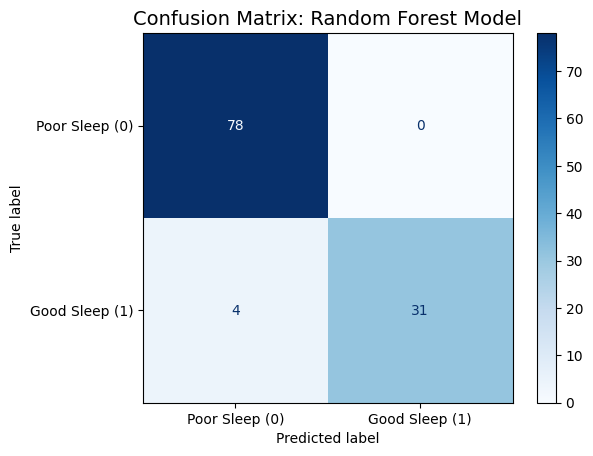

In [21]:
# --- Visualization: Confusion Matrix for Random Forest ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Poor Sleep (0)', 'Good Sleep (1)'])

# Plot
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix: Random Forest Model', fontsize=14)
plt.grid(False) # Turn off grid for cleaner look
plt.show()

In [22]:
# Adding .pkl files.

import joblib
import os

if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(rf_clf, 'models/rf_model.pkl')

joblib.dump(lda, 'models/lda_model.pkl')

joblib.dump(vectorizer, 'models/vectorizer.pkl')

print("Success! Models have been saved to the 'models/' folder.")

Success! Models have been saved to the 'models/' folder.
